In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("data/train.csv", index_col="id")
df_test = pd.read_csv("data/test.csv", index_col="id")

In [3]:
df_train.drop(columns=['Unnamed: 0', 'Gate location', 'Leg room service', 'Baggage handling'], inplace=True)
df_test.drop(columns=['Unnamed: 0', 'Gate location', 'Leg room service', 'Baggage handling'], inplace=True)

In [4]:
X_train = df_train.drop(columns="satisfaction")
y_train = df_train.satisfaction

X_test = df_test.drop(columns="satisfaction")
y_test = df_test.satisfaction

In [5]:
y_train = y_train.replace({'neutral or dissatisfied': 0, 'satisfied': 1})
y_test = y_test.replace({'neutral or dissatisfied': 0, 'satisfied': 1})

# Preprocessor

In [6]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [7]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median'))
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder())
])

ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),    
    ("ordinal", OrdinalEncoder(categories=[['0', '1', '2', '3', '4', '5']] * 11))
])

In [8]:
preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]),
    ("categoric", categorical_pipeline, ['Gender', 'Customer Type', 'Type of Travel', 'Class']),
    ("ordinal", ordinal_pipeline, ['Inflight wifi service',
        'Departure/Arrival time convenient', 'Ease of Online booking', 
        'Food and drink', 'Online boarding', 'Seat comfort',
        'Inflight entertainment', 'On-board service', 'Checkin service', 
        'Inflight service', 'Cleanliness'])
])

# Pipeline

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

In [12]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBClassifier(n_jobs=-1, random_state=42))
])

parameters = {
    "algo__learning_rate": loguniform(0.1, 0.3),
    "algo__max_depth": [9, 10],
    "algo__gamma": loguniform(2, 4),
    "algo__colsample_bytree": loguniform(0.6, 0.8),
    "algo__reg_alpha": loguniform(0.6, 0.8),
    "algo__reg_lambda": loguniform(4, 6)
}

model = RandomizedSearchCV(pipeline, parameters, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print("Best hyperparameters: ", model.best_params_)
print("Best accuracy: ", model.best_score_)
print(f"Training: {model.score(X_train, y_train)*100:.2f}% | Testing: {model.score(X_test, y_test)*100:.2f}%")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters:  {'algo__colsample_bytree': 0.7109662235514159, 'algo__gamma': 3.941904591403078, 'algo__learning_rate': 0.17070059179090855, 'algo__max_depth': 10, 'algo__reg_alpha': 0.7194571167899805, 'algo__reg_lambda': 5.521019924961057}
Best accuracy:  0.9605308979883285
Training: 96.65% | Testing: 96.18%


[[14242   331]
 [  661 10742]]


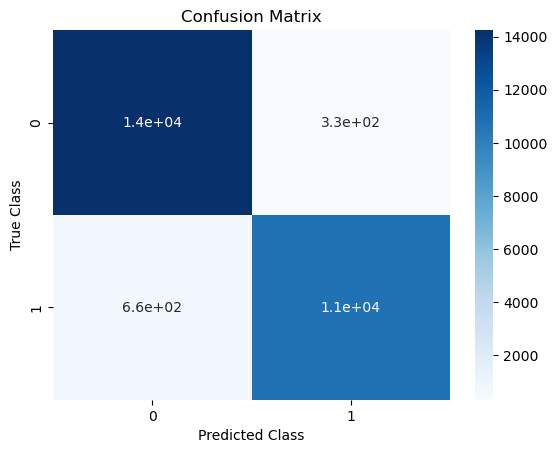

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [14]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14573
           1       0.97      0.94      0.96     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

